### 1. 构建QUBO矩阵
对于 $ N $ 个城市的TSP问题，采用**二进制编码**（ $ N^2 $ 个变量）：
- 变量定义：$ x_{c,t} $（城市c在时间步t被访问=1，否则=0）
- 约束条件：
  1. 每个时间步仅访问1个城市：$\sum_c x_{c,t} = 1$
  2. 每个城市仅访问1次：$\sum_t x_{c,t} = 1$

**QUBO目标函数**：
$$
H = \sum_{t=1}^{N-1} \sum_{c_1,c_2} D_{c_1,c_2} x_{c_1,t} x_{c_2,t+1} + \lambda \left( \sum_{t} \left(1-\sum_c x_{c,t}\right)^2 + \sum_{c} \left(1-\sum_t x_{c,t}\right)^2 \right)
$$
其中 $ D $ 是距离矩阵，$ \lambda $ 是约束权重。

In [167]:
import numpy as np

N = 3
# 比特数2^N
n_qubits = N**2

# 距离矩阵
D = np.array([[0, 2, 3],
              [2, 0, 1],
              [3, 1, 0]])

# 约束权重
lambda_val = np.max(D)

# 初始化QUBO矩阵
Q = np.zeros((n_qubits, n_qubits))

# 填充路径代价项
for t in range(N-1):
    for c1 in range(N):
        for c2 in range(N):
            Q[N*t + c1, N*(t+1) + c2] += D[c1, c2]

# 添加约束项
for t in range(N):
    for c1 in range(N):
        for c2 in range(N):
            Q[N*t + c1, N*t + c2] += lambda_val * (-1 if c1 == c2 else 1)

for c in range(N):
    for t1 in range(N):
        for t2 in range(N):
            Q[N*t1 + c, N*t2 + c] += lambda_val * (-1 if t1 == t2 else 1)

print(Q)


[[-6.  3.  3.  3.  2.  3.  3.  0.  0.]
 [ 3. -6.  3.  2.  3.  1.  0.  3.  0.]
 [ 3.  3. -6.  3.  1.  3.  0.  0.  3.]
 [ 3.  0.  0. -6.  3.  3.  3.  2.  3.]
 [ 0.  3.  0.  3. -6.  3.  2.  3.  1.]
 [ 0.  0.  3.  3.  3. -6.  3.  1.  3.]
 [ 3.  0.  0.  3.  0.  0. -6.  3.  3.]
 [ 0.  3.  0.  0.  3.  0.  3. -6.  3.]
 [ 0.  0.  3.  0.  0.  3.  3.  3. -6.]]


### 2. 将QUBO转换为哈密顿量
QUBO矩阵 $ Q $ 对应的哈密顿量为：
$$
H_p = \sum_{i} Q_{ii} \sigma_z^i + \sum_{i\ne j} Q_{ij} \sigma_z^i \sigma_z^j
$$

In [168]:
from qutip import *

# 生成所有泡利Z算符的组合
def get_pauli_z_terms(n_qubits):
    pauli_z = []
    for i in range(n_qubits):
        op_list = [qeye(2) for _ in range(n_qubits)]
        op_list[i] = sigmaz()
        pauli_z.append(tensor(op_list))
    return pauli_z

# 构建哈密顿量
pauli_z = get_pauli_z_terms(n_qubits)
H_p = qzero([2]*n_qubits)

for i in range(n_qubits):
    for j in range(n_qubits):
        if i == j:
            H_p += Q[i,j] * pauli_z[i]
        else:
            H_p += Q[i,j] * pauli_z[i] * pauli_z[j]

print(H_p)

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2]], shape=(512, 512), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 78.   0.   0. ...   0.   0.   0.]
 [  0.  34.   0. ...   0.   0.   0.]
 [  0.   0.  36. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 120.   0.   0.]
 [  0.   0.   0. ...   0. 118.   0.]
 [  0.   0.   0. ...   0.   0. 186.]]


### 3. 验证哈密顿量基态

In [169]:
# 计算基态（对应最优路径）
evals, evecs = H_p.eigenstates()
ground_state = evecs[0]
print("基态能量:", evals[0])

# 解码路径
def decode_path(state):
    vec = state.full().flatten()
    idx = np.argmax(np.abs(vec))
    binary = format(idx, f'0{n_qubits}b')
    path = []
    for t in range(3):
        for c in range(3):
            if binary[3*t + c] == '1':
                path.append(chr(65 + c))  # A,B,C
    return '->'.join(path)

print("最优路径:", decode_path(ground_state))

基态能量: -48.0
最优路径: C->B->A


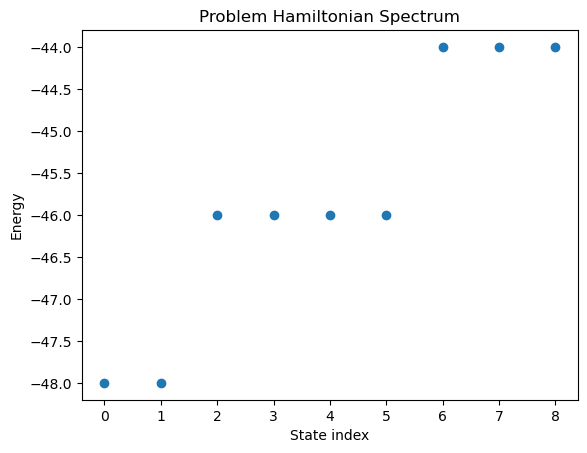

In [170]:
import matplotlib.pyplot as plt

plt.plot(evals[0:9], 'o')
plt.title('Problem Hamiltonian Spectrum')
plt.xlabel('State index');
plt.ylabel('Energy')
plt.show()

### 4. 量子退火模拟

In [171]:
# 初始哈密顿量（横向场）
H_0 = -sum([tensor([sigmax() if i == n else qeye(2) for i in range(n_qubits)]) 
            for n in range(n_qubits)])

# 退火调度
def A(t):
    return 1 - t/T
def B(t):
    return t/T
def H_t(t, args): return A(t)*H_0 + B(t)*H_p

# 运行退火
T = 500.0
tlist = np.linspace(0, T, 100)
psi0 = tensor([(basis(2,0)+basis(2,1)).unit() for _ in range(n_qubits)])
result = sesolve(H_t, psi0, tlist, [])

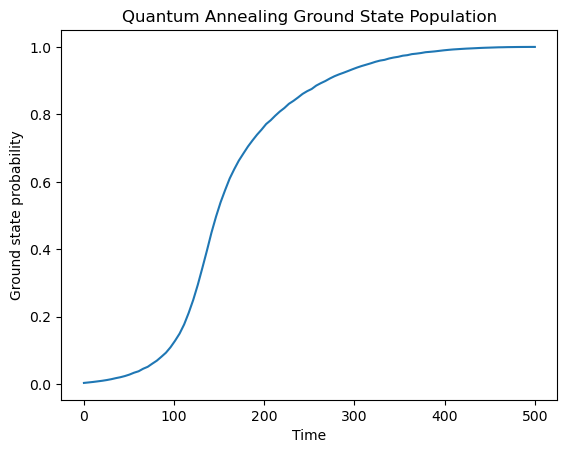

In [172]:
target_ground = (evecs[0] + evecs[1]) / np.sqrt(2)
ground_prob = [fidelity(target_ground, state)**2 for state in result.states]

# 可视化
plt.plot(tlist, ground_prob)
plt.xlabel('Time')
plt.ylabel('Ground state probability')
plt.title('Quantum Annealing Ground State Population')
plt.show()